In [2]:
# To install packages (if needed)
# using Pkg 
# elem_list = ["Distributed", "LsqFit", "Formatting", "JLD", "LaTeXStrings", "Optimization", "Ipopt", "OptimizationOptimJL", "OptimizationOptimisers", "ForwardDiff", "Zygote", "BenchmarkTools", "QuadGK", "Roots", "SharedArrays", "Plots", "PGFPlotsX"]
# for elem in elem_list
#   Pkg.add(elem)
# end

In [3]:
# With parallelisation
using Distributed
# how many threads does processor have
ncores = Sys.CPU_THREADS
addprocs(ncores-nprocs()-6)
println("Processes: ", nprocs())

Processes: 14


In [4]:
@everywhere include("scripts_photon_catching_full.jl")
@everywhere using LsqFit
@everywhere using Formatting
#pgfplotsx() # much slower, than default, but should be prettier for the plots!

In [5]:
# a function that saves a plt to a file via pgfplotsx backend. then modifies the .tex file by removing comments at the beginning and adding a header, and begin and end document
function plt2pdf(plt, filename::String="filename"; dpi=96, width=10, height=8, preview::Bool=true, directory::String="Plots", header::String=raw"\documentclass[groupedaddress,amsmath,amssymb,amsfonts,nofootinbib,a4paper, 10pt]{standalone}"*"\n"*raw"\input{../tikz_header}")
    # width and height are in cm
    pixel_width = width / 2.54 * dpi
    pixel_height = height / 2.54 * dpi
    plot!(plt, framestyle=:box, size=(pixel_width, pixel_height))
    # get the extent of plt (xlims and ylims)
    x_lims = xlims(plt)
    y_lims = ylims(plt)
    # construct a box at the border
    box = [(x_lims[1], y_lims[1]), (x_lims[1], y_lims[2]), (x_lims[2], y_lims[2]), (x_lims[2], y_lims[1]), (x_lims[1], y_lims[1])]
    plot!(plt, box, color=:black, linewidth=1, label="")
    # plot the box
    plot!(plt, xlims=x_lims, ylims=y_lims)
    # create completed filename
    dir_name = joinpath(directory, filename)
    # if .tex missing add it
    if !endswith(dir_name, ".pdf")
        dir_name = dir_name * ".pdf"
    end
    # if directory missing create it
    if !isdir(directory)
        mkdir(directory)
    end
    # save plt to file, then load it
    savefig(plt, dir_name)
    if preview
        display(plt)
    end
end
function stringx(x, N=2)
    return sprintf1("%1.$(N)f",x)
end

stringx (generic function with 2 methods)

In [6]:
# optimize kappa for different g and T values
omega = 10.0
n = 3
redo = false
n_g, n_T = 91, 99
g_s::Vector{Float64} = range(0.1, 1.0, length=n_g)
T_s::Vector{Float64} = range(1.0, 50.0, length=n_T)
kappa_opt_s = SharedArray{Float64}(n_g, n_T)
C = SharedArray{Float64}(n_g, n_T)
filename = joinpath("Results", "optimal_kappa_" * string(n) * "_" * params_to_str("g", g_s) * "_" * params_to_str("T", T_s) * "_w_"*string(omega)*".jld")
if isfile(filename) && !redo
    dict = load(filename, "dict")
    println("Loaded")
else
    if !isfile(filename)
        println("File does not exist, Optimizing")
    else
        println("Redoing optimization")
    end
    for i in 1:n_g
        g = g_s[i]
        if i%10 == 0
            println("g = ", g, " (", i, "/", n_g, ")")
        end
        @sync @distributed for j in 1:n_T
            T = T_s[j]
            param = Parameters(g, 1.0, omega, T)
            kappa_opt, P_s_val = find_optimal_k(param, n, max_delta=100.0, reltol=1e-6)
            kappa_opt_s[i, j] = kappa_opt
            # Cooperativity
            C[i,j] = 4.0* g^2 / ( kappa_opt * omega )
        end
    end
    dict = Dict("g_s" => g_s, "T_s" => T_s, "kappa_opt_s" => Array(kappa_opt_s), "C" => Array(C))
    println("Done")
    save(filename, "dict", dict)
    println("Saved")
end

Loaded


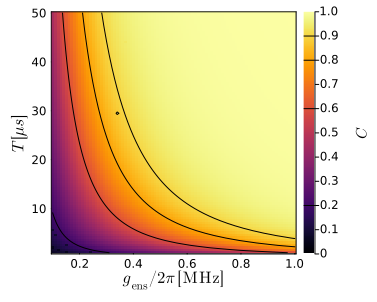

In [7]:
g_s = dict["g_s"]
T_s = dict["T_s"]
C = dict["C"]
plt = plot()
heatmap!(plt, g_s, T_s, C', xlabel=L"g_\mathrm{ens}/2\pi \; [\mathrm{MHz}]", ylabel=L"T \; [\mu s]", colorbar_title=" \n"*L"C", clims=(0, 1.0), right_margin = 5Plots.mm)
# add a hightmap at points:
#height_vals = [0.682, 0.954, 0.997]
height_vals = [0.2, 0.6, 0.8, 0.9]#, 0.95]
contour!(plt, g_s, T_s, C', levels=height_vals, color=:black, linewidth=1, label="", right_margin = 5Plots.mm)
plt2pdf(plt, "fig12") #C_of_g_T

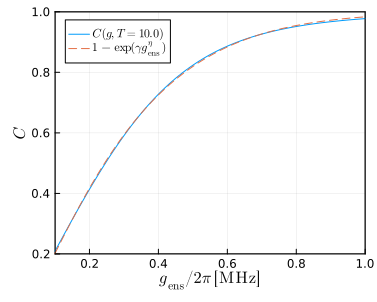

L"$\gamma = 4.10\pm0.01$"

L"$\eta = 1.259\pm0.003$"

In [8]:
# look at cuts through C
# C(g)
T_ind = 19
plt = plot()
plot!(plt, g_s[1:end], C[1:end, T_ind], xlabel=L"g_\mathrm{ens}/2\pi \; [\mathrm{MHz}]", ylabel=L"C", label=latexstring("C(g, T="*string(T_s[T_ind])*")"))
# fit to 1- exp(-c*g^2)
c_of_g = (x, p) -> 1.0 .- exp.(-p[1] .*x.^p[2])

# ues optimization to find p
fit = curve_fit(c_of_g, g_s[1:end], C[1:end, T_ind], [0.1,0.2], autodiff=:forwarddiff)
cooperativity_coeffs = coef(fit)
plot!(plt, g_s[1:end], c_of_g(g_s[1:end], cooperativity_coeffs), label=L"1-\exp(\gamma g_\mathrm{ens}^\eta)", linestyle=:dash)
plot!(plt, xlims=(0.1, 1.0), ylims=(0.2, 1.0)) #ylims=(minimum(C[1:end, T_ind]), 1.0))
plt2pdf(plt, "C_of_g_at_T_"*string(T_s[T_ind]))
std = stderror(fit)
display(latexstring(raw"\gamma = "*stringx(cooperativity_coeffs[1])*raw"\pm"*stringx(std[1])))
display(latexstring(raw"\eta = "*stringx(cooperativity_coeffs[2],3)*raw"\pm"*stringx(std[2],3)))


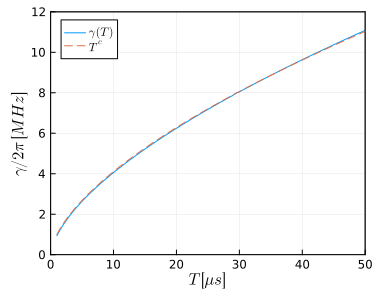

L"$c = 0.6136\pm0.0001$"

In [9]:
# fit_fun for every T_ind 
fit_fun = (x, p) -> 1.0 .- exp.(-p[1] .*x.^1.25)
gamma_T = SharedArray{Float64}(n_T)
@sync @distributed for T_ind in 1:n_T
    fit = curve_fit(fit_fun, g_s[2:end], C[2:end, T_ind], [0.1])
    gamma_T[T_ind] = coef(fit)[1]
end
plt = plot()
plot!(plt, T_s, gamma_T, xlabel=L"T \; [\mu s]", ylabel=L"\gamma/2\pi \; [MHz]", label=L"\gamma(T)")
# fit T_s to :
fit_fun = (x, p) ->  x.^p[1]
fit = curve_fit(fit_fun, T_s, gamma_T, [0.1])
c = coef(fit)
plot!(plt, T_s, fit_fun(T_s, c), label=L"T^c", linestyle=:dash)
plot!(plt, xlims=(0.0, 50.0), ylims=(0.0, 12))
plt2pdf(plt, "gamma_of_T")
d_c = stderror(fit)
display(latexstring("c = "*stringx(c[1], 4)*raw"\pm"*stringx(d_c[1], 4)))

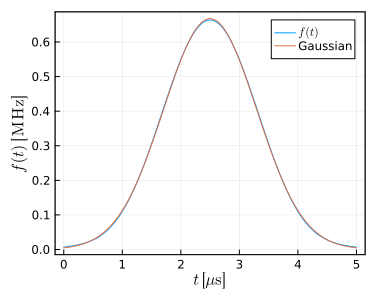

0.0036769982373110466

In [10]:
# Test Gaussian pulse expansion (not a plot for the paper, only consistency check)
# expand function into sinus basis functions
omega = 10.0    
T = 5.0
g = 0.5
kappa = 4*g^2/omega
param = Parameters(g, kappa, omega, T)
kappa_g = 2*pi / param.T 
n = 2
n_zsolt = 11
max_delta = 100.0
reltol=1e-6
coeffs = expand_Zsolt2coeff_full(n_zsolt, kappa_g, param, reltol=reltol)
#coeffs[1] = 0.0
plt, x_arr, t_arr = plot_full_pulse(coeffs, param)
t0 = param.T / 2
fun = (t) -> sqrt(param.kappa * kappa_g) / pi^(1 / 4) * exp(-kappa_g^2 * (t - t0)^2 / 2)
plot!(plt, t_arr, fun.(t_arr), label="Gaussian")
plt2pdf(plt, "gaussian_pulse_fit_test")
# get errors of Zsolts Gaussian and the basis function expansion
diff = x_arr .- fun.(t_arr)
max_err = maximum(abs.(diff))
# P_s ~ |f(t)|^2 -> delta P_s ~ 2 |f(t)| delta f(t) = 2 sqrt(P_s) delta f(t)

In [11]:
# compare accuracy of approximation
n_zsolt = 11
coeffs = expand_Zsolt2coeff_full(n_zsolt, kappa_g, param, reltol=reltol)
integral_cache = analytical_P_s_cache_integrals_full_gaussian(param, n_zsolt, max_delta, reltol)
constraint_matrix = create_harmonic_f_constraint_cache_full(n_zsolt, param, reltol)
# normalize coeffs
coeffs = normalize_coeff(coeffs, param.kappa, constraint_matrix)
Zsolt_P_s = P_s_cached(coeffs, integral_cache)
println("11 Zsolt_P_s: ", Zsolt_P_s)
n_zsolt = 21
coeffs = expand_Zsolt2coeff_full(n_zsolt, kappa_g, param, reltol=reltol)
integral_cache = analytical_P_s_cache_integrals_full_gaussian(param, n_zsolt, max_delta, reltol)
constraint_matrix = create_harmonic_f_constraint_cache_full(n_zsolt, param, reltol)
# normalize coeffs
coeffs = normalize_coeff(coeffs, param.kappa, constraint_matrix)
Zsolt_P_s2 = P_s_cached(coeffs, integral_cache)
println("22 Zsolt_P_s: ", Zsolt_P_s2)
println("ratio: ", Zsolt_P_s2/Zsolt_P_s)

11 Zsolt_P_s: 0.5479449156264038
22 Zsolt_P_s: 0.547979862105502
ratio: 1.0000637773580912


kappa_opt = 0.12142167217308823
Optimized Cooperativity: 0.8235762052218211
Zsolt_P_s: 0.7797304579394038
Optimized P_s: 0.8809442594748494


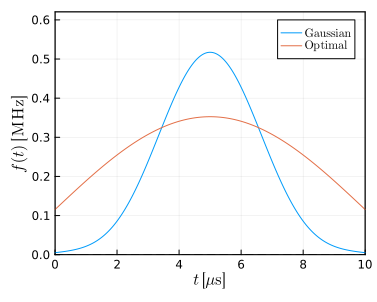

In [12]:
# expand function into sinus basis functions
omega = 10.0    
T = 10.0
g = 0.5
n = 3
n_zsolt = 10
max_delta = 100.0
reltol=1e-9
kappa = 4*g^2/omega
param = Parameters(g, kappa, omega, T)
kappa_opt, P_s_val = find_optimal_k(param, n; max_delta=max_delta, reltol=reltol)
println("kappa_opt = ", kappa_opt)
println("Optimized Cooperativity: ", 4*g^2/(kappa_opt*omega))
param = Parameters(g, kappa_opt, omega, T)

kappa_g = 2*pi / param.T
 
coeffs = expand_Zsolt2coeff_full(n_zsolt, kappa_g, param, reltol=reltol)
integral_cache = analytical_P_s_cache_integrals_full_gaussian(param, n_zsolt, max_delta, reltol)
constraint_matrix = create_harmonic_f_constraint_cache_full(n_zsolt, param, reltol)
# normalize coeffs
coeffs = normalize_coeff(coeffs, param.kappa, constraint_matrix)
Zsolt_P_s = P_s_cached(coeffs, integral_cache)
println("Zsolt_P_s: ", Zsolt_P_s)


integral_cache = analytical_P_s_cache_integrals_full(param, n, max_delta, reltol)
constraint_matrix = create_harmonic_f_constraint_cache_full(n, param, reltol)
coeff = ones(2)# deepcopy(coeffs)
opt_fun = x -> -P_s_cached_normalized(x, integral_cache, constraint_matrix, param.kappa)
opt_fun_diffed = OnceDifferentiable(opt_fun, coeff, autodiff=:forward)
results  = optimize(opt_fun_diffed, coeff, BFGS())#, Optim.Options(callback=cb))
coeff_opt = normalize_coeff(Optim.minimizer(results), param.kappa, constraint_matrix)
optim_result = P_s_cached_normalized(coeff_opt, integral_cache, constraint_matrix, param.kappa)
println("Optimized P_s: ", optim_result)

# plot the pulse of coeffs
plt = plot()
t_arr = Vector(range(0.0, param.T, length=1000))
gauss_vals = full_pulse(t_arr, coeffs, param.T)
pulse_vals = full_pulse(t_arr, coeff_opt, param.T)
plot!(plt, t_arr, gauss_vals, label=L"\mathrm{Gaussian}")
plot!(plt, t_arr, pulse_vals, label=L"\mathrm{Optimal}")
## is the pulse normalized?
c2 = [0.0]
# add horizontal line to y = 0 to plt then display
plot!(plt, [0.0, param.T], [0.0, 0.0], color="black", label="", linestyle=:dash, xlims=(0.0, param.T), ylims=(min(0.0, minimum(pulse_vals)), maximum(gauss_vals)*1.2))
plot!(plt, xlabel=L"t\; [\mu \mathrm{s}]", ylabel=L"f(t)\; [\mathrm{MHz}]")
title!(plt, "")
# save as pdf
plt2pdf(plt, "fig11") #optimized_pulse

In [14]:
# number_of_spin_terms_up_to_order
do_achievable = true
redo = false
g_samples, k_samples, T_samples = 100, 100, 100
if do_achievable
    g_s::Vector{Float64} = range(0.01, stop=1.0, length=g_samples)
    kappa_s::Vector{Float64} = range(0.01, stop=1.0, length=k_samples)
    T_s::Vector{Float64} = range(0.5, stop=50.0, length=T_samples)
else ### large g, but only short T
    g_s::Vector{Float64} = range(0.1, stop=4.0, length=g_samples)
    kappa_s::Vector{Float64} = range(0.1, stop=6.0, length=k_samples)
    T_s::Vector{Float64} = range(0.25, stop=20.0, length=T_samples)
end

omega = 10.0
param = Parameters(1.0, 1.0, omega, 10.0)
n = 3
n_zsolt = 10
reltol=1e-7
max_delta=100.0
target_step = 100
coeff = ones(n)

for do_gauss in [true, false]
    if !do_gauss
        filename = functionname(n, g_s, kappa_s, T_s)
    else
        filename = functionname(n_zsolt, g_s, kappa_s, T_s; prefix = "gaussian_pulses_n_")
    end
    # if filename exists load it, else optimize
    if isfile(filename) && !redo
        dict = load(filename, "dict")
        println("Loaded")
    else
        if !isfile(filename)
            println("File does not exist, Optimizing")
        else
            println("Redoing optimization")
        end
        if !do_gauss
            dict = optimize_catching_photons_T_g_kappa(T_s, g_s, kappa_s, coeff, param, reltol, max_delta, target_step)
        else
            dict = gaussian_catch_photons_T_g_kappa(T_s, g_s, kappa_s, param, n_zsolt, reltol, max_delta, target_step)
        end
        println("Done")
        save(filename, "dict", dict)
        println("Saved")
    end 
end

Loaded
Loaded


Max value: 0.9966533337655046
Max value gaussian: 0.9929672568204315


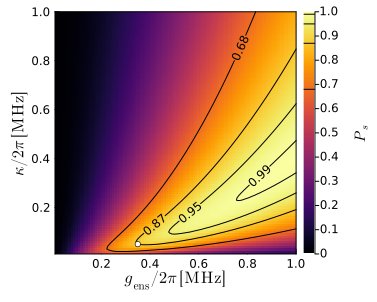

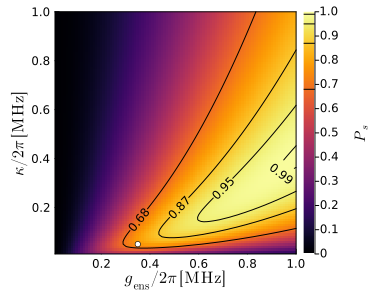

In [15]:
# Plot Heatmap
filename = filename = functionname(n, g_s, kappa_s, T_s)
dict = load(filename, "dict")
filename_gauss = filename = functionname(n_zsolt, g_s, kappa_s, T_s; prefix = "gaussian_pulses_n_")
dict_gauss = load(filename_gauss, "dict")

# find first T at which max value is 99% of max value
max_vals = [maximum(dict["objective"][i,:,:]) for i in 1:length(T_s)]
max_vals_gaussian = [maximum(dict_gauss["objective"][i,:,:]) for i in 1:length(T_s)]
#T_ind = findfirst(max_vals .>= 0.99)
T_ind = findmin(abs.(T_s .- 20.0))[2]
g_s::Vector{Float64} = dict["param"]["g"]
kappa_s::Vector{Float64} = dict["param"]["kappa"]

P_s_values = dict["objective"][T_ind,:,:]
P_s_values_gaussian = dict_gauss["objective"][T_ind,:,:]
# max values
max_val = max_vals[T_ind]
println("Max value: ", max_val)
max_val_gaussian = max_vals_gaussian[T_ind]
println("Max value gaussian: ", max_val_gaussian)

#### Optimization ###################
plt = heatmap(g_s, kappa_s, P_s_values', xlabel=L"g_\mathrm{ens}/2\pi\;[\mathrm{MHz}]", ylabel=L"\kappa/2\pi\;[\mathrm{MHz}]", clim=(0,1), colorbar_title=" \n"*L"P_s", right_margin = 5Plots.mm) #title=latexstring(raw"P_s(T="*string(T_s[T_ind])*raw"\mu s)"), 
contour!(plt, g_s, kappa_s, P_s_values', levels=[0.68, 0.87, 0.95, 0.99], linewidth=1, clabels=true, color=:black, label="")
plot!(plt, xlims=(minimum(g_s), maximum(g_s)), ylims=(minimum(kappa_s), maximum(kappa_s)))
g0, kappa0 = 0.350, 0.050
plot!(plt, [g0], [kappa0], seriestype=:scatter, markersize=3, color=:white, label="", markerstype=:circle)
plt2pdf(plt, "fig10b") #P_s_of_kappa_g_contour_optim

#### Gaussian #######################
plt2=heatmap(g_s, kappa_s, P_s_values_gaussian', xlabel=L"g_\mathrm{ens}/2\pi\;[\mathrm{MHz}]", ylabel=L"\kappa/2\pi\;[\mathrm{MHz}]", clim=(0,1), colorbar_title=" \n"*L"P_s", right_margin = 5Plots.mm) #title=latexstring(raw"P_s(T="*string(T_s[T_ind])*raw"\mu s)"), 
contour!(plt2, g_s, kappa_s, P_s_values_gaussian', levels=[0.68, 0.87, 0.95, 0.99], linewidth=1, clabels=true, color=:black, label="")
plot!(plt2, xlims=(minimum(g_s), maximum(g_s)), ylims=(minimum(kappa_s), maximum(kappa_s)))
plot!(plt2, [g0], [kappa0], seriestype=:scatter, markersize=3, color=:white, label="", markerstype=:circle)
plt2pdf(plt2, "fig10a") #P_s_of_kappa_g_contour_Zsolt

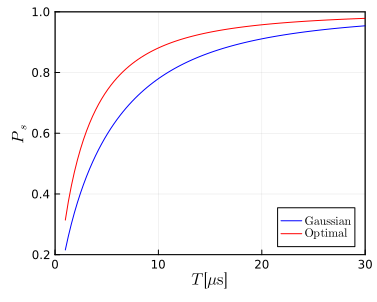

In [16]:
omega = 10.0    
g = 0.5
n_zsolt = 10
n = 3
max_delta = 100.0
reltol=1e-6

T_s::Vector{Float64} = range(1.0, stop=30.0, length=100)
P_s_zsolt = zeros(length(T_s))
P_s_opt = zeros(length(T_s))
for (i, T) in enumerate(T_s)
    param = Parameters(g, 1.0, omega, T)
    kappa_opt, P_s_opt[i] = find_optimal_k(param, n, max_delta=100.0, reltol=1e-6)
    param = Parameters(g, kappa_opt, omega, T)
    kappa_g = 2*pi / param.T
    coeffs = expand_Zsolt2coeff_full(n_zsolt, kappa_g, param, reltol=reltol)
    integral_cache = analytical_P_s_cache_integrals_full(param, n_zsolt, max_delta, reltol)
    constraint_matrix = create_harmonic_f_constraint_cache_full(n_zsolt, param, reltol)
    coeffs = normalize_coeff(coeffs, param.kappa, constraint_matrix)
    P_s_zsolt[i] = P_s_cached(coeffs, integral_cache)
end
# Plot
speedup = P_s_zsolt ./ P_s_opt
plt = plot()
plot!(plt, T_s, P_s_zsolt, label=L"\mathrm{Gaussian}", color=:blue)
plot!(plt, T_s, P_s_opt, label=L"\mathrm{Optimal}", color=:red)
plot!(plt, xlabel=L"T\;[\mu\mathrm{s}]", ylabel=L"P_s", legend=:bottomright)
# line at 0.99
#plot!(plt, [0.0, maximum(T_s)], [0.99, 0.99], color=:black, linestyle=:dash, label="")
plot!(xlims=(0.0, maximum(T_s)), ylims=(0.2, 1.0))
plt2pdf(plt, "Time_2_P_s_Zsolt_vs_optimal")

In [17]:
# Test
redo = false
g_samples = 90
g_s::Vector{Float64} = range(0.1, stop=1.0, length=g_samples)
P_s_list = [0.99, 0.95, 0.68]
target_P_s = P_s_list[1]
omega = 10.0
T = 1.0
min_T = 0.01
max_T = 10000.0
reltol= 1e-10
n = 3
n_zsolt = 10
param = Parameters(1.0, 1.0, omega, T)
coeff = ones(n)

filename = joinpath("Results", "time_2_P_s_"*string(target_P_s)*"_n_" * string(n) * "_"*string(n_zsolt) * "_o_"*string(omega)*"_" * params_to_str("g", g_s) *".jld")
if isfile(filename) && !redo
    println("Loading cached results")
    dict = load(filename)
    T_target = dict["T_target"]
    Zsolt_T_target = dict["Zsolt_T_target"]
else
    println("Calculating results")
    T_target, Zsolt_T_target, kappa_opt = Both_T_g_to_target(target_P_s, n, n_zsolt, g_s, coeff, param, min_T, max_T, reltol=reltol)
    dict = Dict("T_target" => T_target, "Zsolt_T_target" => Zsolt_T_target, "g_s" => g_s, "kappa_opt" => kappa_opt)
    save(filename, dict)
end

plt = plot()
plot!(plt, g_s, Zsolt_T_target, label=L"\mathrm{Gaussian}", color=:blue)
plot!(plt, g_s, T_target, xlabel=L"g_\mathrm{ens}/2\pi\;[\mathrm{MHz}]", ylabel=L"T\;[\mu\mathrm{s}]", label=L"\mathrm{Optimal}", color=:red)
# make y axis logarithmic
plot!(plt, yscale=:log10)
plt2pdf(plt, "Time_2_P_s_Zsolt_vs_optimal_of_g")
### plot the speedup
plt2 = plot()
speedup = Zsolt_T_target ./ T_target
plot!(plt2, g_s, speedup, xlabel=L"g/2\pi\;[\mathrm{MHz}]", ylabel=L"\mathrm{Speedup } \frac{T(\mathrm{Gaussian})}{T(\mathrm{Optimal})}", label="Speedup", color=:green)
plt2pdf(plt2, "Speedup_of_g")

Calculating results


In [20]:
# Test
redo = false
g_samples = 90
P_s_samples = 89
g_s::Vector{Float64} = range(0.1, stop=1.0, length=g_samples)
target_P_s_s::Vector{Float64} = range(0.1, stop=0.99, length=P_s_samples)
omega = 10.0
T = 1.0
min_T = 0.01
max_T = 10000.0
reltol= 1e-10
n = 3
n_zsolt = 10
param = Parameters(1.0, 1.0, omega, T)
coeff = ones(n)

filename = joinpath("Results", "time_2_"*params_to_str("P_s", target_P_s_s) *"_n_" * string(n) * "_"*string(n_zsolt) * "_o_"*string(omega)*"_" * params_to_str("g", g_s) *".jld")
if isfile(filename) && !redo
    println("Loading cached results")
    dict = load(filename)
else
    println("Calculating results")
    T_target = zeros(length(g_s), length(target_P_s_s))
    Zsolt_T_target = zeros(length(g_s), length(target_P_s_s))
    kappa_opt = zeros(length(g_s), length(target_P_s_s))
    for (i, target_P_s) in enumerate(target_P_s_s)
        println("Calculating for target P_s: ", target_P_s, " (", i, "/", length(target_P_s_s), ")" )	    
        T_target[:,i], Zsolt_T_target[:,i], kappa_opt[:,i] = Both_T_g_to_target(target_P_s, n, n_zsolt, g_s, coeff, param, min_T, max_T, reltol=reltol)
    end
    dict = Dict("T_target" => T_target, "Zsolt_T_target" => Zsolt_T_target, "kappa_opt" => kappa_opt, "g_s" => g_s, "target_P_s_s" => target_P_s_s)
    save(filename, dict)
end


Loading cached results


Dict{String, Any} with 5 entries:
  "T_target"       => [5.60249 6.10859 … 785.96 1158.63; 4.63005 5.04849 … 648.…
  "Zsolt_T_target" => [9.99373 10.6642 … 1197.38 1732.09; 8.24233 8.79509 … 987…
  "g_s"            => [0.1, 0.110112, 0.120225, 0.130337, 0.140449, 0.150562, 0…
  "kappa_opt"      => [0.0467648 0.0245803 … 0.00414963 0.00407572; 0.0567051 0…
  "target_P_s_s"   => [0.1, 0.110114, 0.120227, 0.130341, 0.140455, 0.150568, 0…

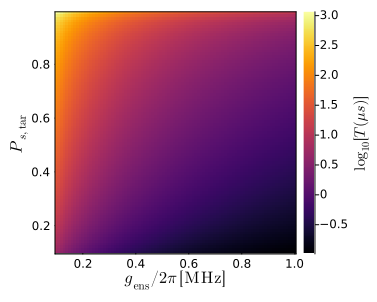

In [21]:
# heatmap of times to P_s logarithmic, with contour lines
# load data from dict
T_target = dict["T_target"]
Zsolt_T_target = dict["Zsolt_T_target"]
g_s = dict["g_s"]
target_P_s_s = dict["target_P_s_s"]
# make color axis logarithmic 
# calculate loagrithmic version of T_target and ticks
T_target_log = log10.(T_target)
exponents = Vector{Int64}(Int64(round(minimum(T_target_log))):Int64(round(maximum(T_target_log))))
ticks = [10.0^i for i in exponents]
tick_labels = [latexstring(raw"10^{"*string(i)*"}") for i in exponents] 
plt = heatmap(g_s, target_P_s_s, T_target_log', xlabel=L"g_\mathrm{ens}/2\pi\;[\mathrm{MHz}]", ylabel=L"P_{s, \mathrm{tar}}", colorbar_title=" \n"*L"\log_{10}[T(\mu s)]", clim=(minimum(T_target_log), maximum(T_target_log)), colorbar_ticks=(exponents, tick_labels), right_margin = 5Plots.mm)
# add contour lines
#contour!(plt, g_s, target_P_s_s, T_target_log', levels=[-1.0, 0.0, 1.0, 2.0, 3.0], linewidth=1, clabels=true, color=:black, label="")
plt2pdf(plt, "fig13a") #Time_2_P_s_heatmap_optim

In [ ]:
# Speedup
speedup = Zsolt_T_target ./ T_target
plt = heatmap(g_s, target_P_s_s, speedup', xlabel=L"g_\mathrm{ens}/2\pi\;[\mathrm{MHz}]", ylabel=L"P_{s, \mathrm{tar}}", colorbar_title=" \n"*L"T_\mathrm{Gauss}/T_\mathrm{Optim}", right_margin = 10Plots.mm, clim=(minimum(speedup), maximum(speedup)))
plt2pdf(plt, "fig13b") #Speedup_heatmap_optim